# Astrophysical lab I
Student: Samson Mercier <samson.mercier18@gmail.com>
Teacher: Carlo Ferrigno <carlo.ferrigno@unige.ch>

## Title
Spectral and timing variability of magnetized neutron stars
## Abstract
Magnetized neutron stars accreting from a companion star emit X-ray radiation that is strongly modulated with the spin phase. They are also variables on time scales varying from seconds to months.
By analyzing the pulsed emission, it is possible to study the emission mechanism and its geometry in the vicinity of the neutron star, where extreme gravity and radiation conditions are present.
By analyzing the variability on different time scales, it is possible to study how the neutron star interact with the surrounding medium to capture the material to be accreted.
The student will be asked to familiarize with one or two X-ray facilities and their data format as well as data reduction pipelines.
Then, specific tools used for spectral and timing analysis will be applied to the reduced data sets and results visualized using python notebooks. Note that many methods are common to several research fields and can be used beyond the high-energy-astrophysics domain.
Even if the student will be asked to contribute to the development of parts of the analysis and visualization tools using standard software versioning, most of the technical details will be mitigated by using software containers and self-developed python packages.
The student will be asked to read and summarize research papers and provide a written report of their work that includes a literature review. 

## Day 1 Familiarize with X-ray data
## Instrumentation.
* https://cxc.harvard.edu/cdo/xray_primer.pdf
(We will not use Chandra, but rather XMM-Newton and NuSTAR, but the data format is very similar)

* https://heasarc.gsfc.nasa.gov/docs/nustar/nustar_tech_desc.html
(to have an Idea of the instrument)

## Specific NuSTAR processing
All information is available here https://heasarc.gsfc.nasa.gov/docs/nustar/analysis/nustar_swguide.pdf


## I extracted cleaned event files for the observation of Cen X-3 with ID 30101055002
We concentrate here on the unit A. There are 3 files:
- FPMA_3.0_7.0_cl_barycorr.evt
- sourceA.evt
- backgroundA.evt

In [2]:
#To be executed just once to unpack the data
#!tar xfz CenX-3_nustar_events.tgz

### EX visualize the structure of the fits file 
- (suggestion, use astropy, either with tables or with io.fits) `import astropy.io.fits as pf` 
- Explain the meaning of different extensions, header keywords, and columns
- Understand the concept of Good Time Intervals (GTIs)

In [40]:
# Importing libraries 
# Can do this to make matplotlib plots interactive: %matplotlib notebook
import astropy.io.fits as pf
import os
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from stingray import Lightcurve
from astropy.timeseries import LombScargle
import scipy.stats as st
import math as mt 

def epoch_fold(time, period):
    Tc_JD = Periodo_file[1].header['MJDREFI']+Periodo_file[1].header['MJDREFF']
    phasefold_time = ((time - Tc_JD)/period) % 1
    return phasefold_time


In [427]:
# opening fits file showing information of source
file1 = pf.open('sourceA.evt')
file1.info()
Event_file=file1[1]
GTI_file=file1[2]

Filename: sourceA.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  EVENTS        1 BinTableHDU    580   1387011R x 15C   [1D, 1D, 1B, 1B, 1B, 16X, 1I, 1J, 1J, 1I, 1I, 1I, 1I, 1I, 1I]   
  2  GTI           1 BinTableHDU     52   255R x 2C   [1D, 1D]   
  3  REG00101      1 BinTableHDU     79   1R x 6C   [1PD(1), 1PD(1), 16A, 1PD(1), 1PD(0), 1PI(1)]   


In [5]:
#Looking at Event file headers
Event_file.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   43 / width of table in bytes                        
NAXIS2  =              1387011 / Number of events                               
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   15 / number of fields in each row                   
TTYPE1  = 'TIME    '           / Time elapsed since MJDREF                      
COMMENT = 'The value in TIME combines the packet timestamp with the             
COMMENT subseconds d                                                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '        

In [6]:
# Looking at GTI file headers
GTI_file.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   16 / width of table in bytes                        
NAXIS2  =                  255 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    2 / number of fields in each row                   
TTYPE1  = 'START   '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = 's       '           / physical unit of field                         
TTYPE2  = 'STOP    '           / label for field   2                            
TFORM2  = '1D      '        

In [7]:
# Doing random stuff to see why the time between two events is not equal to the livetime 
# between two events. 
# Solution: there is dead time in between each event where detector is in cool down and can't 
# be activated again.
timediff=Event_file.data['TIME'][1:11]-Event_file.data['TIME'][:10]
livetime_diff=Event_file.data['PRIOR'][:10]
print(timediff, livetime_diff)
print('fraction diff is', timediff/livetime_diff)
#Fraction is not the same everywhere, weird

[0.02933171 0.01631683 0.01257318 0.00364056 0.01674002 0.00362211
 0.00560135 0.01892763 0.0068883  0.0228416 ] [0.03197279 0.02587986 0.01001655 0.00983025 0.00122362 0.01381171
 0.0013874  0.00311069 0.01478265 0.00435459]
fraction diff is [ 0.91739608  0.63048385  1.25524117  0.37034263 13.68074595  0.26224948
  4.03730643  6.08470462  0.46597204  5.24541176]


In [8]:
#looking at data in fits file to understand what to do
Event_file.data

FITS_rec([(1.86603042e+08, 0.03197279, 0,  4, 4, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -8, 104, 208, 205, 336, 299, 538, 474),
          (1.86603042e+08, 0.02587986, 0,  8, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 258, 213, 224, 342, 318, 535, 454),
          (1.86603042e+08, 0.01001655, 0,  5, 1, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -34, 124, 193, 208, 322, 303, 523, 477),
          ...,
          (1.86641788e+08, 0.03613118, 0,  8, 5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 147, 212, 224, 335, 315, 537, 476),
          (1.86641788e+08, 0.00510817, 0, 11, 8, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -9,  65, 226, 239, 349, 330, 544, 456),
          (1.86641788e+08, 0.01635173, 0, 15, 9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4, -29, 151, 230, 259, 353, 350, 538, 437)],
         dtype=(numpy.record, [('TIME', '>f8'), ('PRIOR', '>f8'), ('DET_ID', 'u1'), ('RAWX', 'u1'), ('RAWY', 'u1'), ('STATUS',

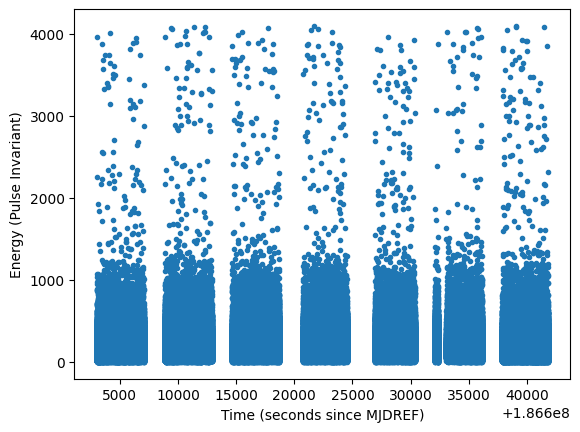

In [9]:
#Plotting energy against time profile
plt.plot(Event_file.data['TIME'], Event_file.data['PI'], '.')
plt.xlabel('Time (seconds since MJDREF)')
plt.ylabel('Energy (Pulse Invariant)')
plt.show()

### EX: Explain what it mean the barycentric correction: in which time system are the times in the events ?

The time system used for the timing of events is the number of seconds since a modified Julian date of reference.

### EX Visualize the light curve choosing a proper time binning and energy range. Light curve = event rate per unit time.
Suggestions, use one of:
- xselect (domain specific, available from the hesoft installation in the docker)
- lcurve (domain specific, available from the hesoft installation in the docker)
- stingray (https://iopscience.iop.org/article/10.3847/1538-4357/ab258d/meta python package in development)
- develop your own routine, 

In [10]:
#Using Stingray to plot a lightcurve i.e. plot of event rate against time

#getting time of events
time = Event_file.data['TIME']

#Getting GTI for the lightcurve 
#Had to change the data format of GTIs so that it would pass through the Stingray function
#GTI_file.data has type astropy.io.fits.fitsrec.FITS_rec and need to input an array of tuples
gtis=[]
for i in GTI_file.data:
    gtis.append((i['START'], i['STOP']))

#Making time and count arrays
tc = Lightcurve.make_lightcurve(time, dt=10, gti=gtis)

In [11]:
tc.time.shape

(3874,)

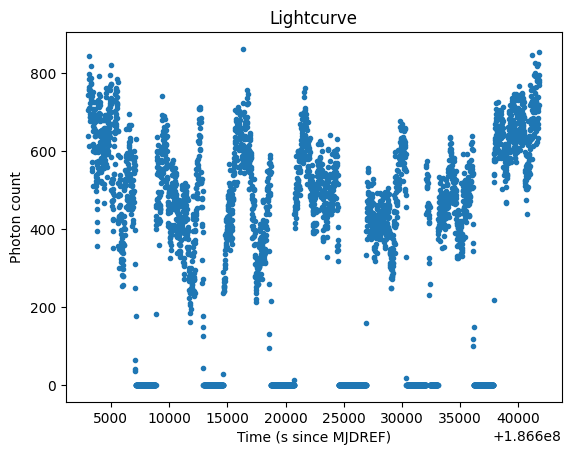

In [12]:
# Using stingray package to plot time and count arrays 
plt.plot(tc.time, tc.counts, '.')
plt.title('Lightcurve')
plt.xlabel('Time (s since MJDREF)')
plt.ylabel('Photon count')
plt.show()

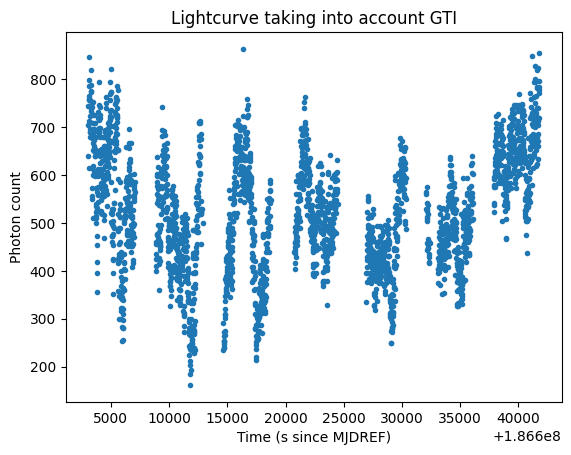

In [13]:
# Applying GTI to remove values going to zero 
tc.apply_gtis()
plt.plot(tc.time, tc.counts, '.')
plt.xlabel('Time (s since MJDREF)')
plt.ylabel('Photon count')
plt.title('Lightcurve taking into account GTI')
plt.show()

399


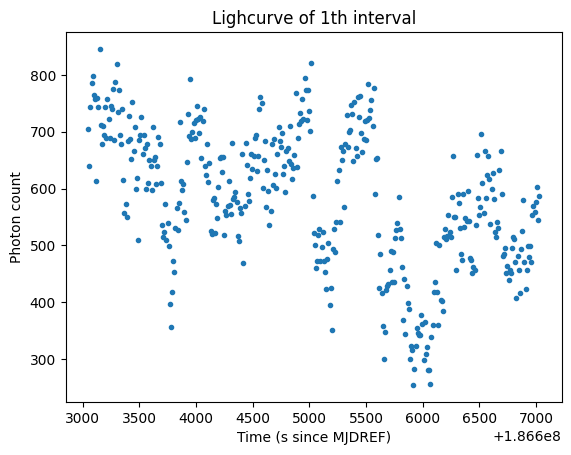

393


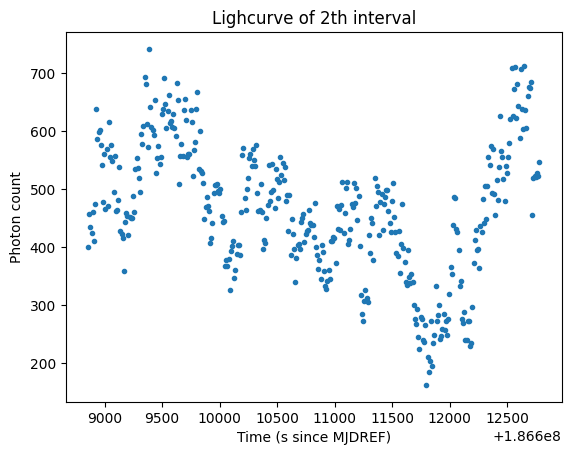

390


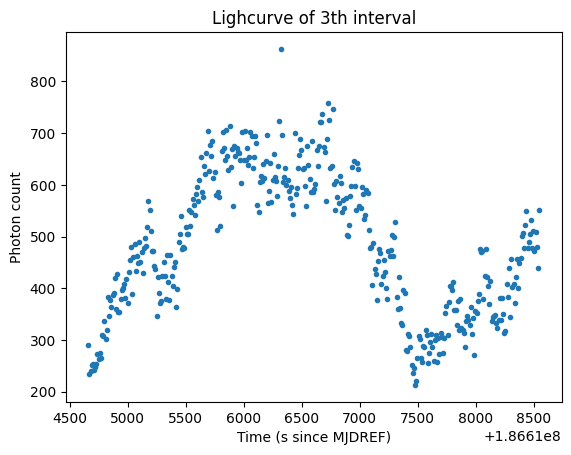

10
367


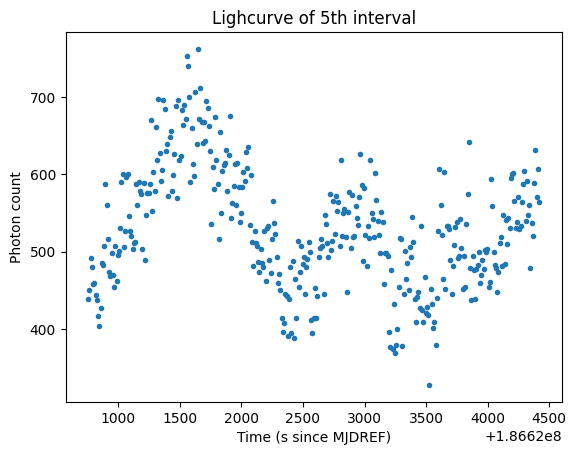

339


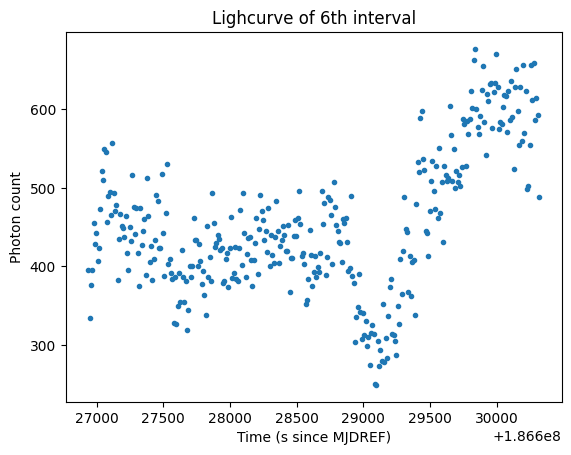

24
3
299


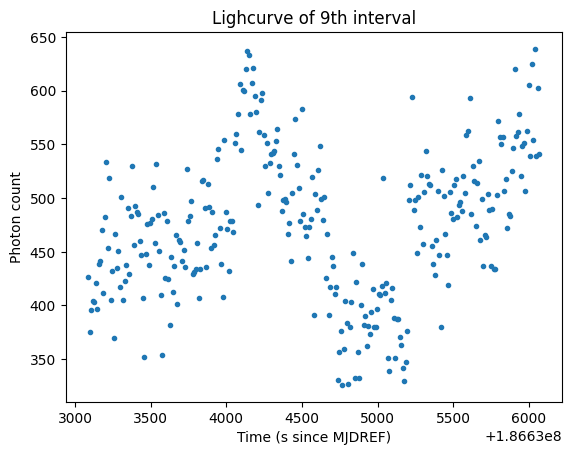

391


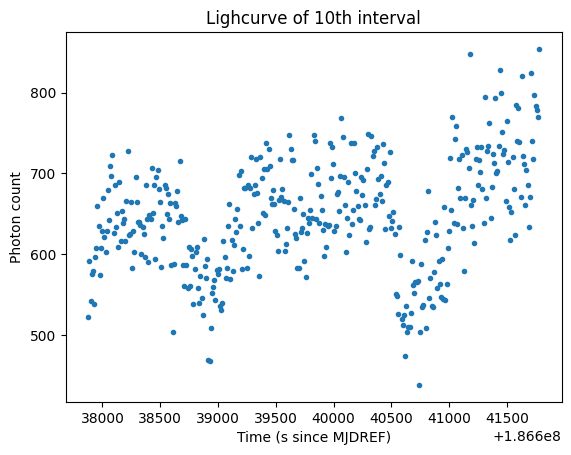

In [14]:
#Split lightcurve by GTIs and plot the relevant ones
tc_split = tc.split_by_gti()
for j, i in enumerate(tc_split):
    print(len(i))
    if len(i) > 200:
        plt.plot(i.time, i.counts, '.')
        plt.title('Lighcurve of '+str(j+1)+'th interval')
        plt.xlabel('Time (s since MJDREF)')
        plt.ylabel('Photon count')
        plt.show()

### EX visualize an image of the three different event files
- suggestion xselect domain specific
- 2dhist in python (which columns to use?)
What is in these files?

In [42]:
#Plotting image seen on detector A -> containing background + source
image_file1 = pf.open('FPMA_3.0_7.0_cl_barycorr.evt')
image_file1.info()
Event_image = image_file1[1].data

Filename: FPMA_3.0_7.0_cl_barycorr.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  EVENTS        1 BinTableHDU    576   1533166R x 15C   [1D, 1D, 1B, 1B, 1B, 16X, 1I, 1J, 1J, 1I, 1I, 1I, 1I, 1I, 1I]   
  2  GTI           1 BinTableHDU     94   255R x 2C   [1D, 1D]   
  3  BADPIX        1 BinTableHDU    119   13R x 5C   [1B, 1B, 1D, 1D, 16X]   
  4  BADPIX        2 BinTableHDU    119   32R x 5C   [1B, 1B, 1D, 1D, 16X]   
  5  BADPIX        3 BinTableHDU    119   32R x 5C   [1B, 1B, 1D, 1D, 16X]   
  6  BADPIX        4 BinTableHDU    146   56R x 5C   [1B, 1B, 1D, 1D, 16X]   


In [43]:
Event_image

FITS_rec([(1.86603042e+08, 0.03197279, 0,  4,  4, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -8, 104, 208, 205, 336, 299, 538, 474),
          (1.86603042e+08, 0.02587986, 0,  8,  5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 258, 213, 224, 342, 318, 535, 454),
          (1.86603042e+08, 0.00075935, 2, 30, 12, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 2,   9, 874, 116,  26, 244, 121, 535, 674),
          ...,
          (1.86641788e+08, 0.03613118, 0,  8,  5, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0, -11, 147, 212, 224, 335, 315, 537, 476),
          (1.86641788e+08, 0.00510817, 0, 11,  8, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0,  -9,  65, 226, 239, 349, 330, 544, 456),
          (1.86641788e+08, 0.01635173, 0, 15,  9, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4, -29, 151, 230, 259, 353, 350, 538, 437)],
         dtype=(numpy.record, [('TIME', '>f8'), ('PRIOR', '>f8'), ('DET_ID', 'u1'), ('RAWX', 'u1'), ('RAWY', 'u1'), ('ST

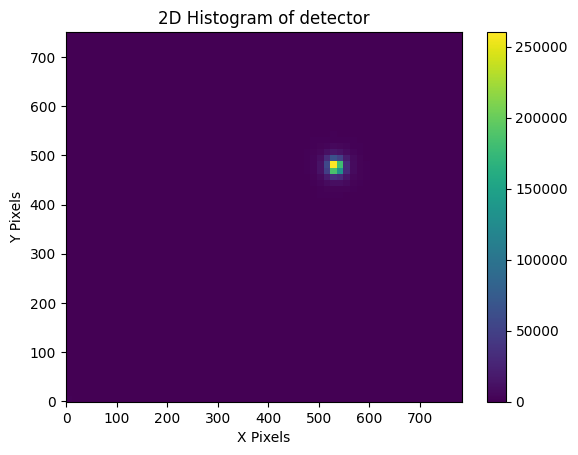

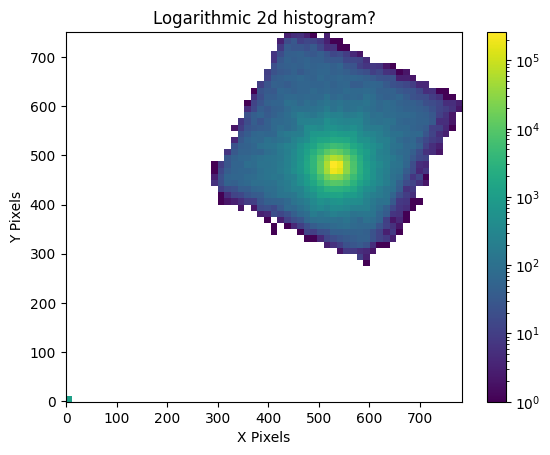

In [44]:
#Plotting 2D histogram with x and y coord of events on detector
import matplotlib.colors as colors
X_coord = Event_image['X']
Y_coord = Event_image['Y']

#Making normal 2D histogram
plt.hist2d(X_coord, Y_coord, bins=(60,60))
plt.title('2D Histogram of detector')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()
plt.show()

#Making logarithmic 2D histogram
plt.hist2d(X_coord, Y_coord, bins=(60,60), norm="log")
plt.title('Logarithmic 2d histogram?')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.colorbar()
plt.show()

### EX find the pulse period
- you should obtain a value like in https://gammaray.nsstc.nasa.gov/gbm/science/pulsars/lightcurves/cenx3.html for the time of observation (please find it)
Suggestions: 
- make a power pectrum
- make a Lomb Scargle Periodogram
- make epoch folding

Compre results

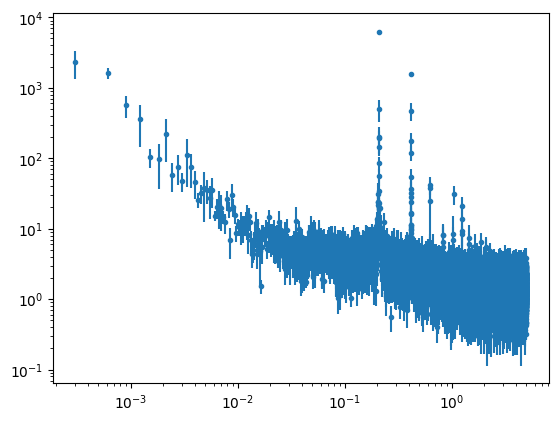

First maximum at: 0.20843505859375
Second maximum at: 0.4168701171875
Third maximum at : 0.62530517578125
The ratio of second maximum freq. to first maximum freq. is 2.0
The ratio of third maximum freq. to first maximum freq. is 3.0


In [33]:
#Plotting power spectrum

#openinng power spectrum file
PS_file = pf.open('FPMA_3.0_7.0_cl_barycorr.fps')
PS_res = PS_file[1]

#getting quantities
freq = PS_res.data['FREQUENCY']
power = PS_res.data['POWER']
err = PS_res.data['ERROR']

#Making loglog plot
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
ax.set_yscale('log')
ax.errorbar(freq, power, yerr=err, fmt='.')
plt.show()
#Getting frequency of first maximum 
print('First maximum at:', freq[np.argmax(power)])
#Making a new power array AFTER the first maximum to find the second maximum
new_power = power[np.argmax(power)+2:]
#Getting frequency of 2nd maximum
print('Second maximum at:', freq[np.argmax(power)+2+np.argmax(new_power)])
#Making a new power array AFTER the second maximum to find the third maximum
new_new_power = new_power[np.argmax(new_power)+3:]
#Getting frequency of 3rd maximum
print('Third maximum at :', freq[np.argmax(power)+np.argmax(new_power)+np.argmax(new_new_power)+5])

#Making sure the maximums are proportional to each other i.e. they are harmonics (?)
print('The ratio of second maximum freq. to first maximum freq. is', freq[np.argmax(power)+2+np.argmax(new_power)]/freq[np.argmax(power)])
print('The ratio of third maximum freq. to first maximum freq. is', freq[np.argmax(power)+np.argmax(new_power)+np.argmax(new_new_power)+5]/freq[np.argmax(power)])


/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Fourier Transform of Power')

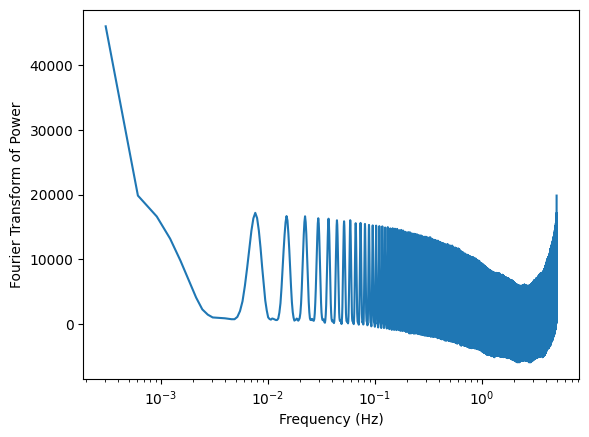

In [34]:
plt.plot(freq, np.fft.fft(power))
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier Transform of Power')

In [8]:
# Making a periodogram
Periodo_file=pf.open('sourceA.evt')
Periodo_data=Periodo_file[1].data
freq2, power2 = LombScargle(Periodo_data['TIME'], Periodo_data['PI']).autopower()

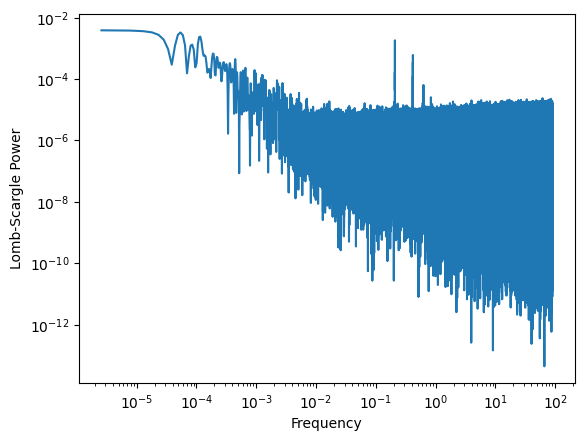

In [20]:
fig=plt.figure()
ax=plt.axes()
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Frequency')
ax.set_ylabel('Lomb-Scargle Power')
ax.loglog(freq2, power2)

In [47]:
#Getting frequency of maximum power

#Cutting off frequencies (and power associated) that are due to red noise 
ind=freq2>0.01
new_freq2=freq2[ind]
new_power2=power2[ind]

#Getting frequency of maximum power
freq2_max = new_freq2[np.argmax(new_power2)]
print('Harmonic frequency is:', freq2_max)

Harmonic frequency is: 0.20849711797967518


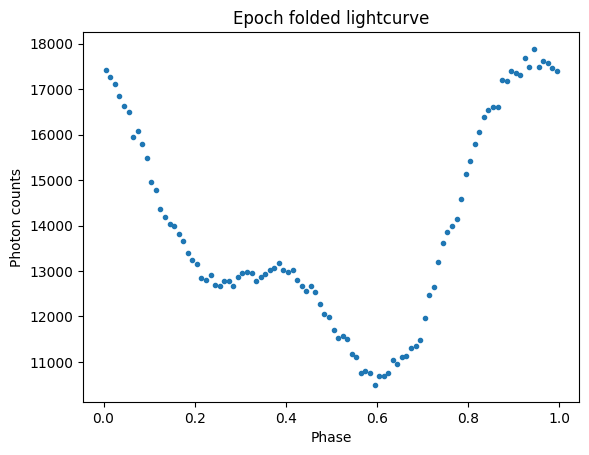

In [48]:
#Epoch folding the curve
def epoch_fold(time, period):
    Tc_JD = Periodo_file[1].header['MJDREFI']+Periodo_file[1].header['MJDREFF']
    phasefold_time = ((time - Tc_JD)/period) % 1
    return phasefold_time

epoch_time = epoch_fold(Periodo_data['TIME'], 1/freq2_max)
new_tc = Lightcurve.make_lightcurve(epoch_time, dt=0.01)
plt.plot(new_tc.time, new_tc.counts,'.')
plt.xlabel('Phase')
plt.ylabel('Photon counts')
plt.title('Epoch folded lightcurve')
plt.show()

### EX Make and plot a Time phase matrix
- Divide the observation in time intervals and for each time interval make a phase profile
- For each profile compute the phase of the main harmonic (fourier decomposition)
- Plot it as function of time
- What do you see ? (hint, frequency derivative ?)

In [2]:
#Getting data (again)
Time_phase_file = pf.open('sourceA.evt')
Time_phase_data=Time_phase_file[1].data

#Changing number of events so that it's divisible by 20
size=1387000
#Getting sizes of bins
seg_size = int(size/20)
#Making lists that will contain the 20 segments of time and PI data
Time_segments = []
PI_segments = []
#Populating the time and PI segment lists
for i in range(20):
    Time_segments.append(Time_phase_data['TIME'][seg_size*i:seg_size*(i+1)])
    PI_segments.append(Time_phase_data['PI'][seg_size*i:seg_size*(i+1)])

#Plotting them all next to each other
#TODO

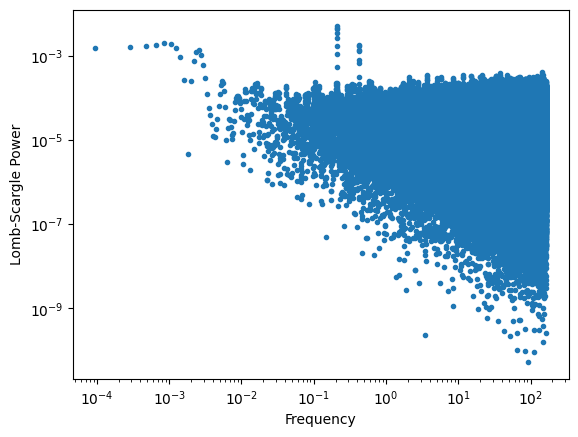

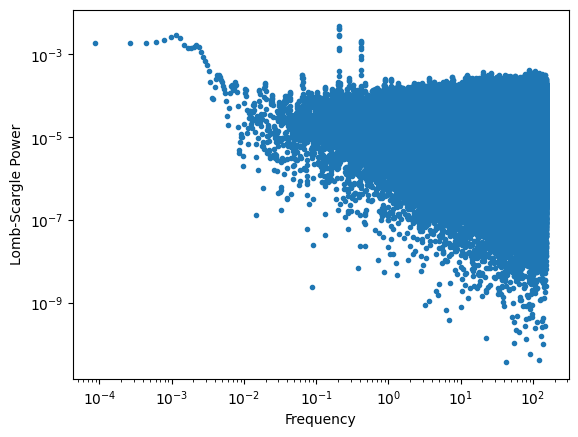

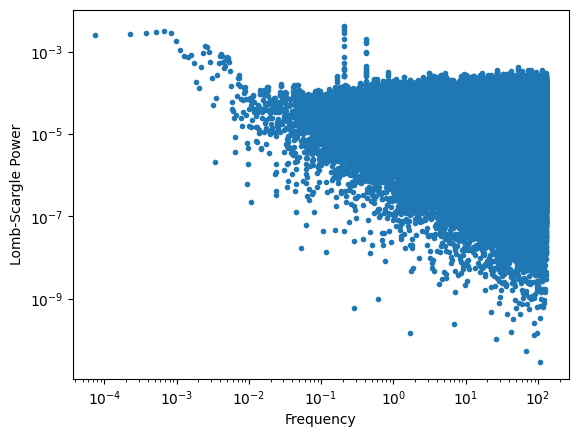

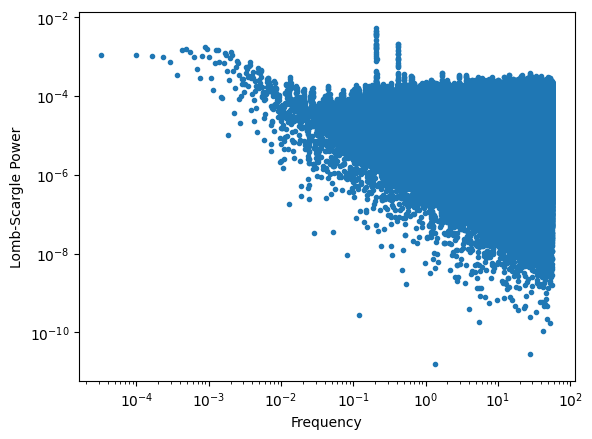

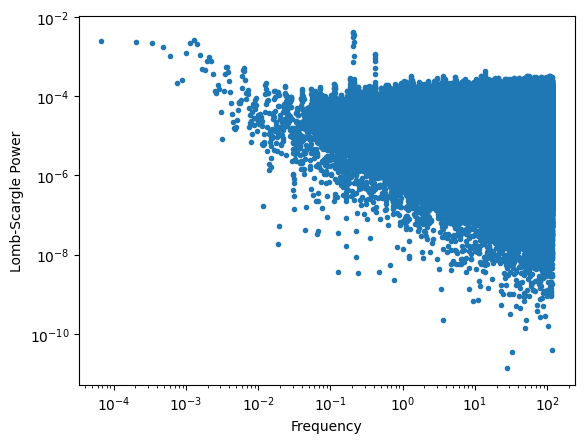

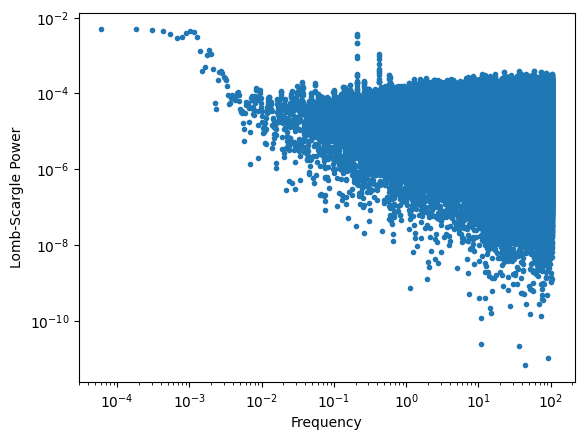

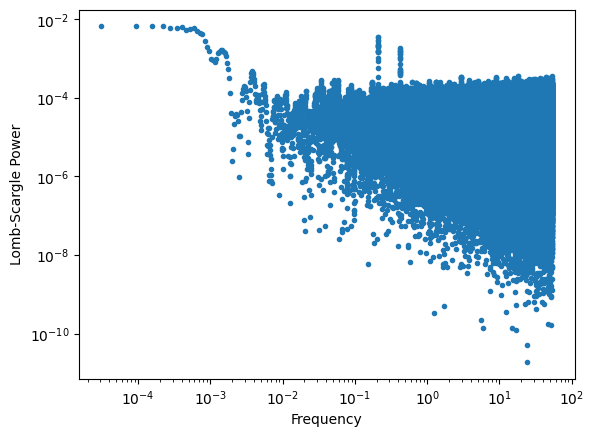

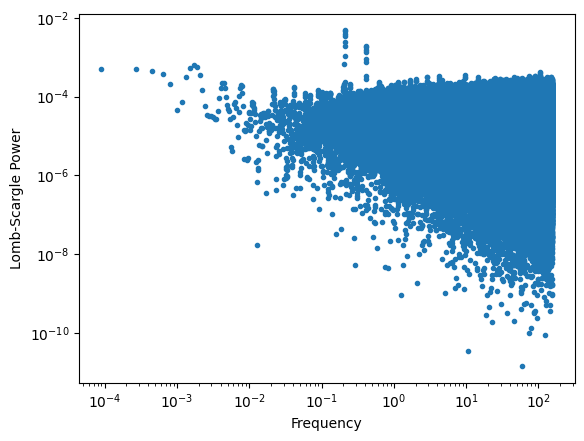

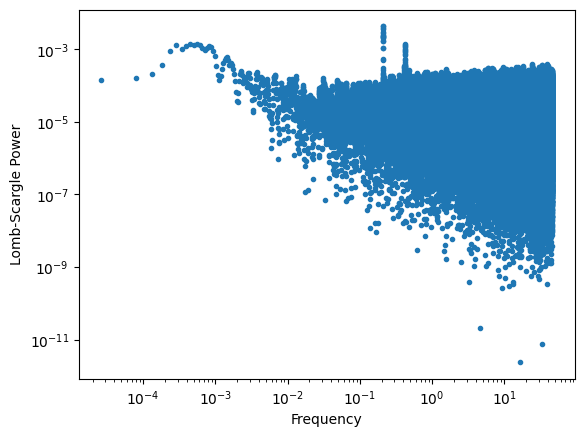

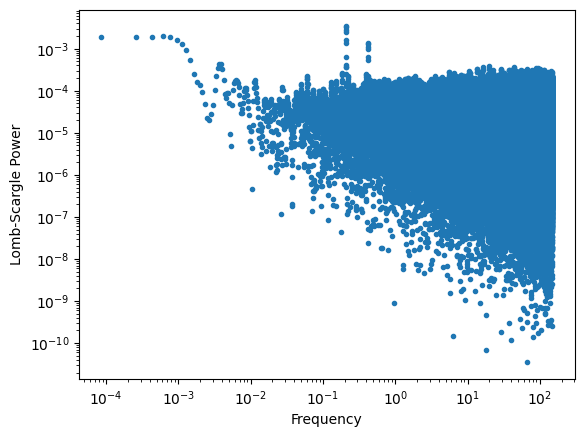

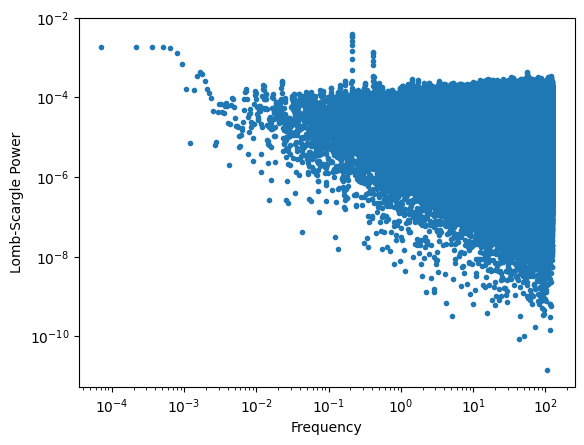

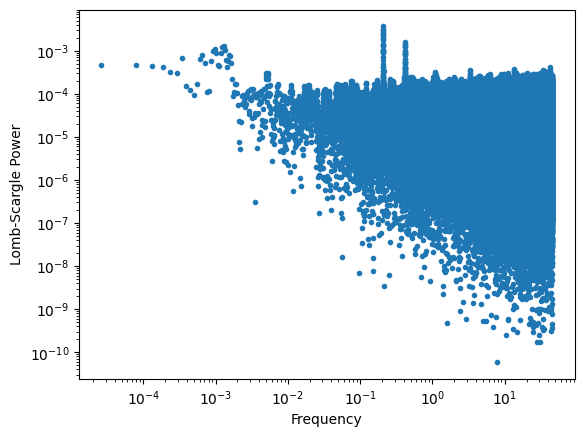

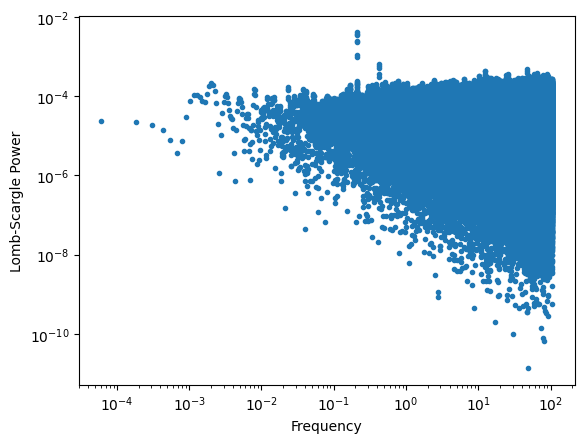

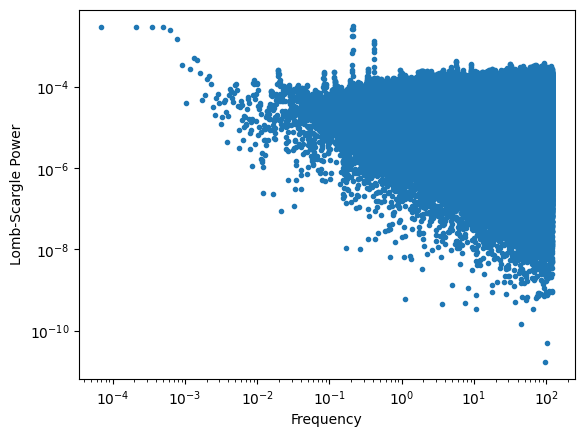

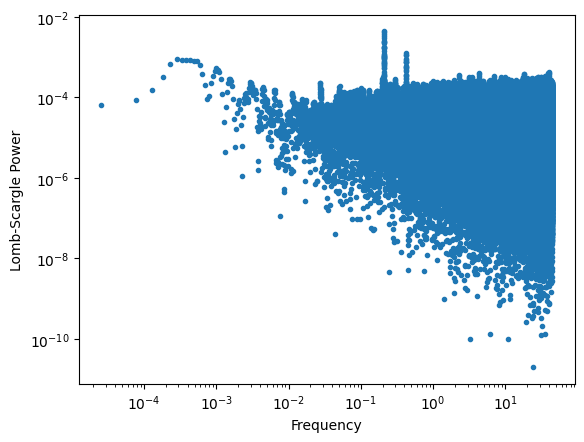

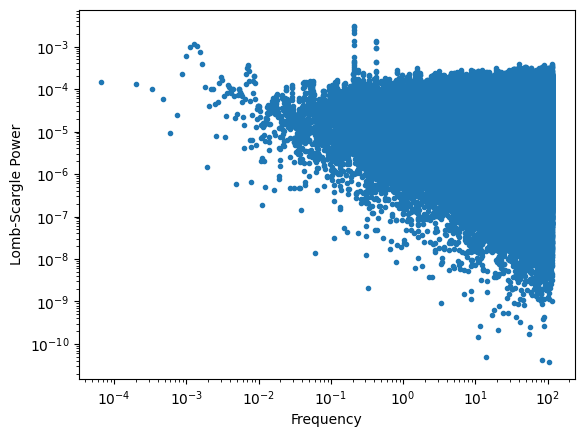

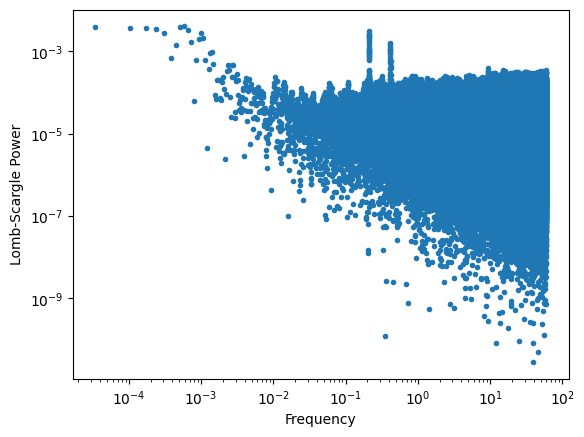

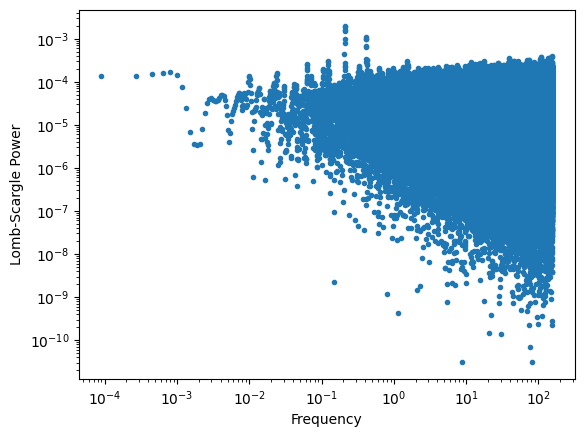

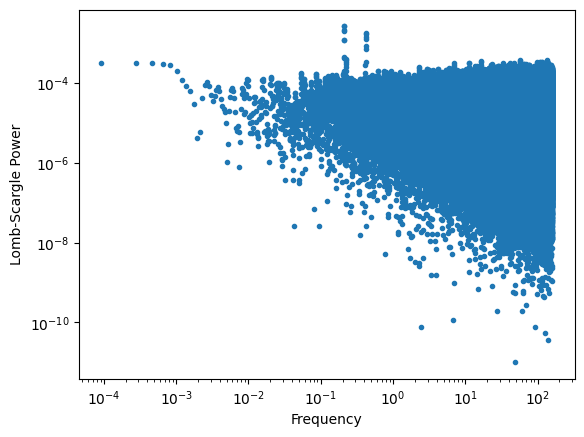

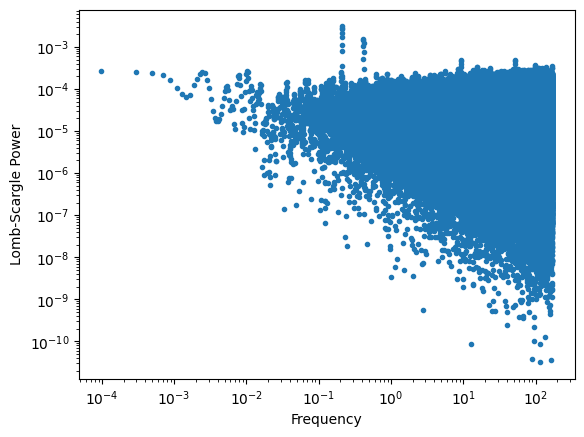

In [3]:
#Getting the periodogram for each of them 
freq_segments = []
Power_segments = []
for i in range(20):
    freq_temp, power_temp = LombScargle(Time_segments[i], PI_segments[i]).autopower()
    freq_segments.append(freq_temp)
    Power_segments.append(power_temp)   
    
for i in range(20):
    plt.loglog(freq_segments[i], Power_segments[i], '.')
    plt.xlabel('Frequency')
    plt.ylabel('Lomb-Scargle Power')
    plt.show()

The harmonic frequency for bin 0 is: 0.2084934998700296
The harmonic frequency for bin 1 is: 0.2085483665065105
The harmonic frequency for bin 2 is: 0.20846055182175388
The harmonic frequency for bin 3 is: 0.20850731846683432
The harmonic frequency for bin 4 is: 0.2085557711439916
The harmonic frequency for bin 5 is: 0.20856255570542467
The harmonic frequency for bin 6 is: 0.2085328239325111
The harmonic frequency for bin 7 is: 0.2085027925578744
The harmonic frequency for bin 8 is: 0.20847393136144277
The harmonic frequency for bin 9 is: 0.20861405968224622
The harmonic frequency for bin 10 is: 0.2084455482832971
The harmonic frequency for bin 11 is: 0.20847022233786622
The harmonic frequency for bin 12 is: 0.2084535533250073
The harmonic frequency for bin 13 is: 0.2084812318380816
The harmonic frequency for bin 14 is: 0.20841968387246368
The harmonic frequency for bin 15 is: 0.20836110430859284
The harmonic frequency for bin 16 is: 0.20842022654536618
The harmonic frequency for bin 1

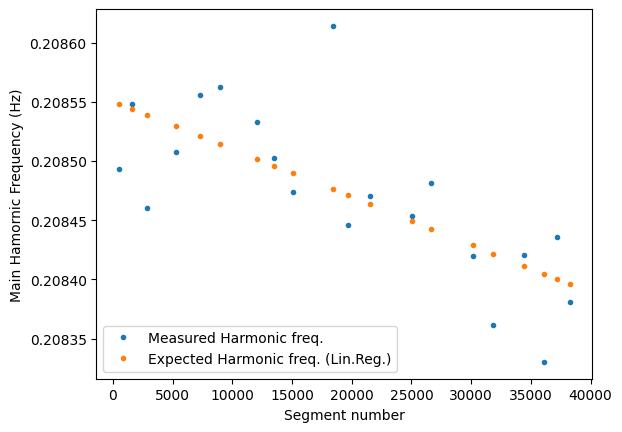

In [401]:
#Get the harmonic frequency

#Cutting off frequencies (and power associated) that are due to red noise 
Harmonic=[]
bins = []
for i in range(20):
    bins.append(np.mean(Time_segments[i]-REF_file.data['TIME'][0]))
    temp_1 = freq_segments[i] > 0.01
    temp_2 = freq_segments[i][temp_1]
    temp_3 = Power_segments[i][temp_1]
    temp_freq_max = temp_2[np.argmax(temp_3)]
    Harmonic.append(temp_freq_max)
    print('The harmonic frequency for bin '+str(i)+' is:', temp_freq_max)
    
#We do a linear regression to get the derivative of frequency with respect to time
#and use it in the re-calculation of the phase folding. 
plt.plot(bins, Harmonic, '.', label='Measured Harmonic freq.')
reg = st.linregress(bins, Harmonic)
new_Harmonics = [reg.intercept + reg.slope*i for i in bins]
plt.plot(bins, new_Harmonics, '.', label='Expected Harmonic freq. (Lin.Reg.)')
plt.xlabel('Segment number')
plt.ylabel('Main Hamornic Frequency (Hz)')
plt.legend()
plt.show()

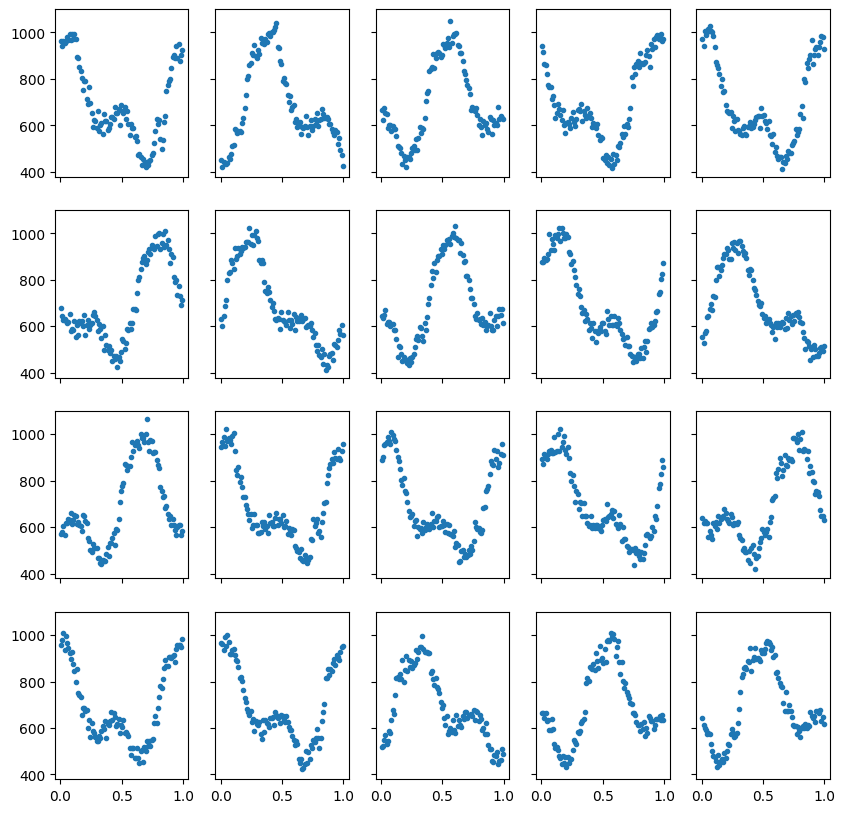

In [9]:
#Getting the folded lightcurve for each of them
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20)) = plt.subplots(4, 5, sharex=True, figsize=(10, 10), sharey=True)
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20]
for i in range(20):
    temp_epoch_t = epoch_fold(Time_segments[i], 1/Harmonic[i])
    temp_tc = Lightcurve.make_lightcurve(temp_epoch_t, dt=0.01)
    axs[i].plot(temp_tc.time, temp_tc.counts,'.')


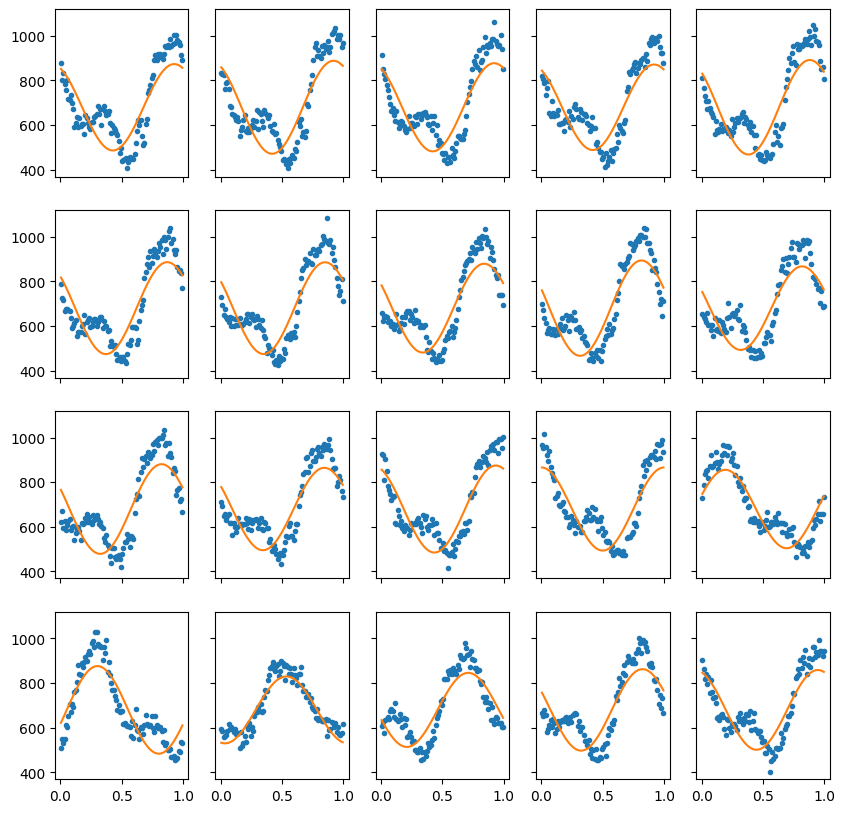

In [402]:
def new_phase_fold(REF_file, time, intercep=0.20849711797967518, slope=0):
    Tc_JD = REF_file.data['TIME'][0]
    phasefold_time = ((time - Tc_JD)*intercep + 0.5*slope*(time - Tc_JD)**2)%1
    return phasefold_time

#Create variable pointing to file containing reference time
REF_file = Time_phase_file[1]

#Create array that will contain the phase value of 1st harmonic for 
#each bin/segment 

phases = []
#Create figure variables
new_f, ((new_ax1, new_ax2, new_ax3, new_ax4, new_ax5), (new_ax6, new_ax7, new_ax8, new_ax9, new_ax10), 
        (new_ax11, new_ax12, new_ax13, new_ax14, new_ax15),
        (new_ax16, new_ax17, new_ax18, new_ax19, new_ax20))= plt.subplots(4, 5, sharex=True, figsize=(10, 10), sharey=True)
new_axs = [new_ax1,new_ax2,new_ax3,new_ax4,new_ax5,new_ax6,new_ax7,new_ax8,new_ax9,new_ax10,new_ax11
       ,new_ax12,new_ax13,new_ax14,new_ax15,new_ax16,new_ax17,new_ax18,new_ax19,new_ax20]

for i in range(20):
    #Re-computing pulse profiles using the new epoch folding function
    test_phase_fold = new_phase_fold(REF_file, Time_segments[i])
    test_lc = Lightcurve.make_lightcurve(test_phase_fold, dt=0.01)
    
    #Fourier transform the pulse profiles
    counts_fft = np.fft.rfft(test_lc.counts)
    
    #Get the phase from Fourier transformed pulse profiles
    phase = np.arctan2(counts_fft.imag, counts_fft.real)
    phases.append(phase[1])
    #Create frequency array for plotting -- DEBUGGING
    size = len(counts_fft)
    freqs = np.fft.fftfreq(counts_fft.shape[0])
    #Plot the pulse profile and the cosine obtained from phase of first harmonic frequency
    new_axs[i].plot(test_lc.time, test_lc.counts, '.')
    new_axs[i].plot(test_lc.time, (counts_fft.real[0]/2+(np.sqrt(counts_fft.imag**2 + counts_fft.real**2)[1]*np.cos(2*np.pi*test_lc.time + phase[1])))/size)
    

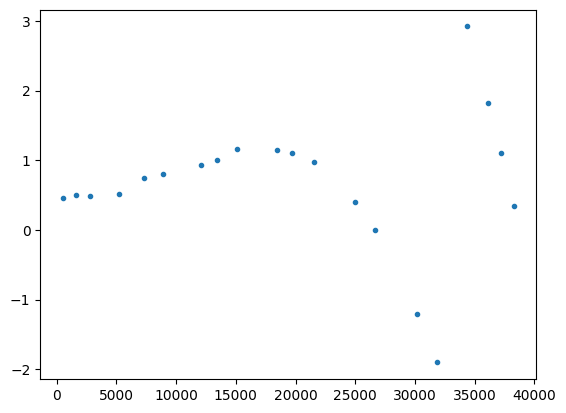

In [403]:
plt.plot(bins, phases, '.')

20 16
[-3.65623956e-13  1.01107258e-08 -2.72540597e-05  4.87435797e-01]


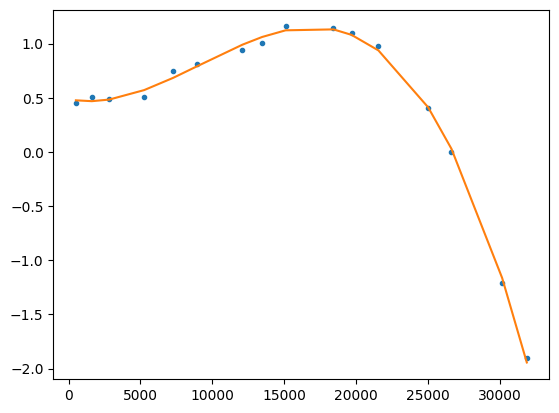

In [404]:
#Plotting the phase of 1st harmonic for each segment as a function of time
cut_phases = phases[:-4]
cut_bins = np.array(bins[:-4])
print(len(phases), len(cut_phases))
plt.plot(cut_bins, cut_phases, '.')
reg2 = np.polyfit(cut_bins, cut_phases, 3)
print(reg2)
plt.plot(cut_bins, reg2[0]*cut_bins**3 + reg2[1]*cut_bins**2 + reg2[2]*cut_bins + reg2[3])
plt.show()
#plt.plot(cut_bins, cut_phases - (reg2[0]*cut_bins**2 + reg2[1]*cut_bins + reg2[2]), '.')

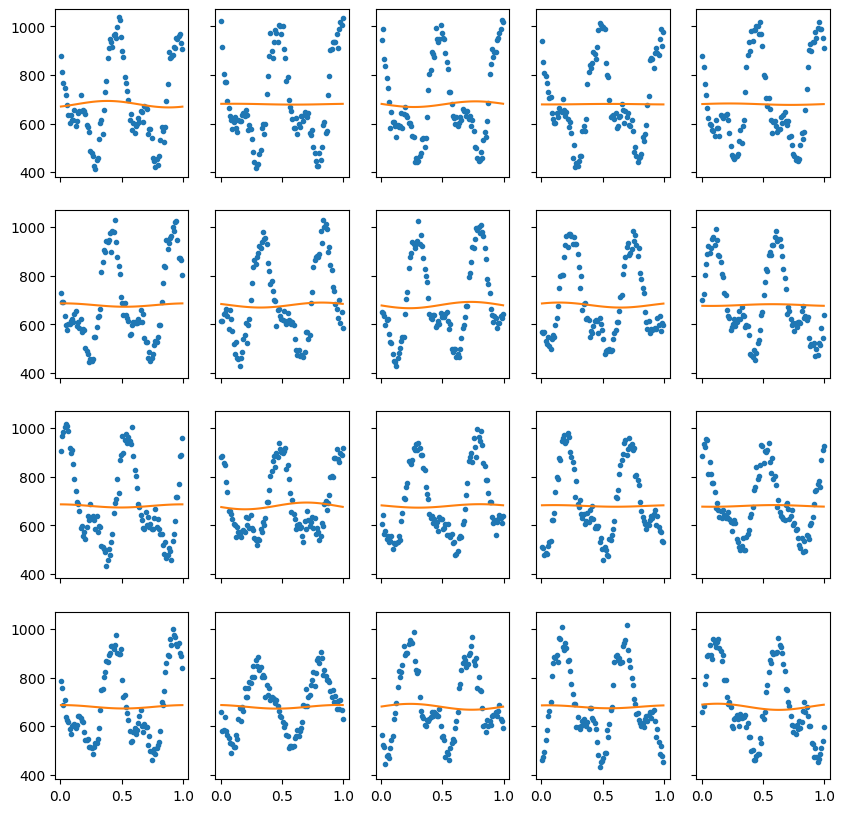

In [421]:
def new_new_phase_fold(REF_file, time, intercep=0.20849711797967518-reg2[2], slope=-reg2[1], trip=-2*reg2[0]):
    Tc_JD = REF_file.data['TIME'][0]
    phasefold_time = ((time - Tc_JD)*intercep + 0.5*slope*(time - Tc_JD)**2 + 0.16*trip*(time - Tc_JD)**3)%1
    return phasefold_time

#Create variable pointing to file containing reference time
REF_file = Time_phase_file[1]

#Create array that will contain the phase value of 1st harmonic for 
#each bin/segment 

phases = []
#Create figure variables
new_f, ((new_ax1, new_ax2, new_ax3, new_ax4, new_ax5), (new_ax6, new_ax7, new_ax8, new_ax9, new_ax10), 
        (new_ax11, new_ax12, new_ax13, new_ax14, new_ax15),
        (new_ax16, new_ax17, new_ax18, new_ax19, new_ax20))= plt.subplots(4, 5, sharex=True, figsize=(10, 10), sharey=True)
new_axs = [new_ax1,new_ax2,new_ax3,new_ax4,new_ax5,new_ax6,new_ax7,new_ax8,new_ax9,new_ax10,new_ax11
       ,new_ax12,new_ax13,new_ax14,new_ax15,new_ax16,new_ax17,new_ax18,new_ax19,new_ax20]

for i in range(20):
    #Re-computing pulse profiles using the new epoch folding function
    test_phase_fold = new_new_phase_fold(REF_file, Time_segments[i])
    test_lc = Lightcurve.make_lightcurve(test_phase_fold, dt=0.01)
    
    #Fourier transform the pulse profiles
    counts_fft = np.fft.rfft(test_lc.counts)
    
    #Get the phase from Fourier transformed pulse profiles
    phase = np.arctan2(counts_fft.imag, counts_fft.real)
    phases.append(phase[1])
    #Create frequency array for plotting -- DEBUGGING
    size = len(counts_fft)
    freqs = np.fft.fftfreq(counts_fft.shape[0])
    #Plot the pulse profile and the cosine obtained from phase of first harmonic frequency
    new_axs[i].plot(test_lc.time, test_lc.counts, '.')
    new_axs[i].plot(test_lc.time, (counts_fft.real[0]/2+(np.sqrt(counts_fft.imag**2 + counts_fft.real**2)[1]*np.cos(2*np.pi*test_lc.time + phase[1])))/size)
    

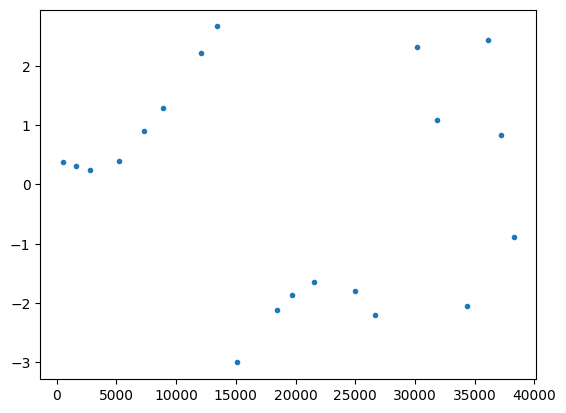

In [418]:
plt.plot(bins, phases, '.')

20 15


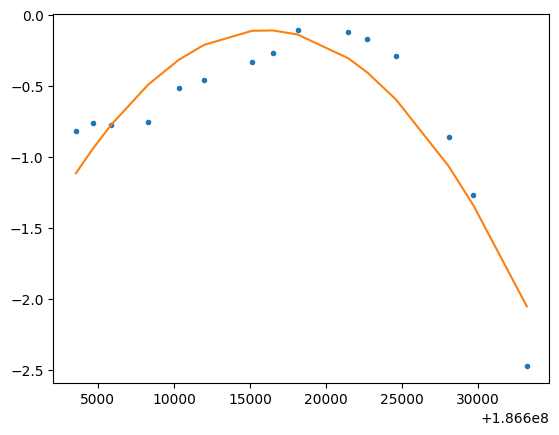

[-6.54770736e-09  2.44381337e+00 -2.28027287e+08]


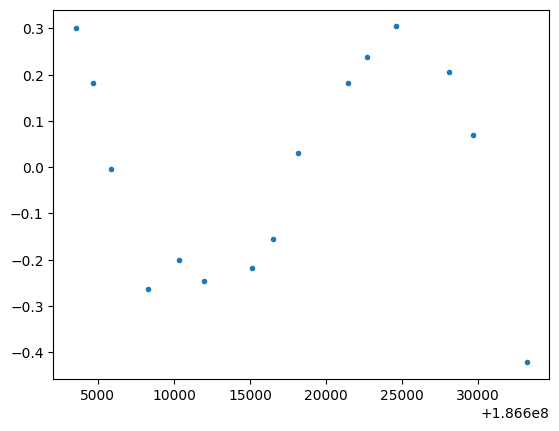

In [325]:
#Plotting the phase of 1st harmonic for each segment as a function of time
cut_phases = phases[:-5]
cut_bins = np.array(bins[:-5])
print(len(phases), len(cut_phases))
plt.plot(cut_bins, cut_phases, '.')
reg2 = np.polyfit(cut_bins, cut_phases, 2)
plt.plot(cut_bins, reg2[0]*cut_bins**2 + reg2[1]*cut_bins + reg2[2])
plt.show()
plt.plot(cut_bins, cut_phases - (reg2[0]*cut_bins**2 + reg2[1]*cut_bins + reg2[2]), '.')
print(reg2)

In [ ]:
st.rvs()
#Mean should br vslur 

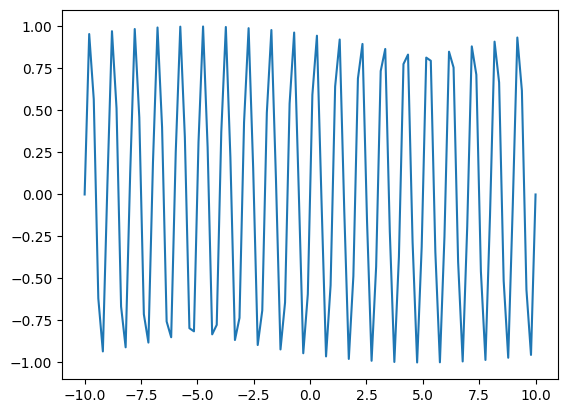

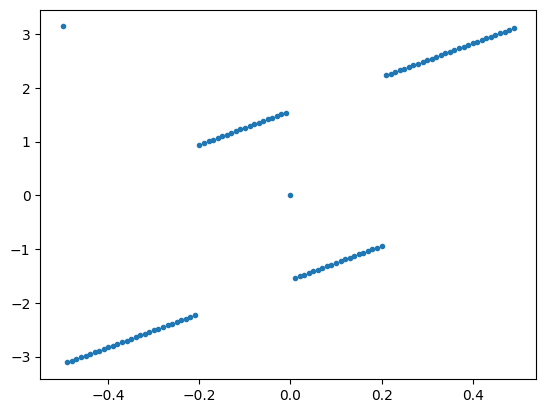

"#Plotting the function (basic)\nplt.plot(x, y_3, 'b.')\nplt.plot(x, y_4, 'r.')\nplt.show()\n#Getting the Fourier transform of the function\ny_3_fft = np.fft.fft(y_3)\nfreqs = np.fft.fftfreq(y_3_fft.shape[0])\nplt.plot(freqs, y_3_fft.imag, 'b.')\nplt.show()\ny_4_fft = np.fft.fft(y_4)\nfreqs = np.fft.fftfreq(y_4_fft.shape[0])\nplt.plot(freqs, y_4_fft.imag, 'r.')\nplt.show()"

In [131]:
#Trying to get better with FFT
#Do this later 
x=np.linspace(-10, 10, 100)
y_0 = np.sin(2*np.pi*x)
y_1 = np.sin(5*x)
y_2 = 3*np.sin(4*x)
y_3 = 3*np.sin(0.0275*x) + 5*np.cos(0.0168*x)
y_4 = 3*np.sin(275*x) + 5*np.cos(168*x)

plt.plot(x, y_0)
plt.show()
y_0_fft = np.fft.fft(y_0)
freqs_0 = np.fft.fftfreq(y_0_fft.shape[0])
phase = np.zeros(y_0_fft.shape)
for i in range(len(y_0_fft)):
    phase[i] = mt.atan2(y_0_fft.imag[i], y_0_fft.real[i])
plt.plot(freqs_0, np.arctan2(y_0_fft.imag, y_0_fft.real) , '.')
plt.show()
'''#Plotting the function (basic)
plt.plot(x, y_3, 'b.')
plt.plot(x, y_4, 'r.')
plt.show()
#Getting the Fourier transform of the function
y_3_fft = np.fft.fft(y_3)
freqs = np.fft.fftfreq(y_3_fft.shape[0])
plt.plot(freqs, y_3_fft.imag, 'b.')
plt.show()
y_4_fft = np.fft.fft(y_4)
freqs = np.fft.fftfreq(y_4_fft.shape[0])
plt.plot(freqs, y_4_fft.imag, 'r.')
plt.show()'''

### EX Orbital correction
- The neutron star is on a binary orbit, it is subject to Doppler shift
- It is necessary to compute the times on the lines of nodes of the system using Kepler's equation

(https://gitlab.astro.unige.ch/ferrigno/timingsuite/-/blob/master/src/binarycor.c) I do my own correction, maybe in stingray or other, there is something similar

In [422]:
import os
os.getcwd()

'/Users/samsonmercier/Desktop/UNIGE/ap-lab-i-2022/notebooks'

In [424]:
frequency,sig_frequency, chisq = np.loadtxt('ef_periodogram_f.qdp', skiprows=5, unpack=True)

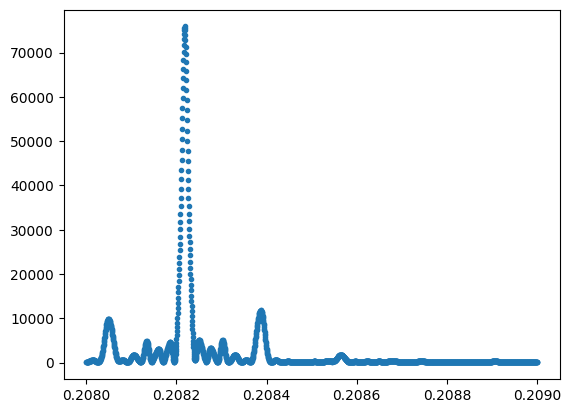

In [425]:
plt.plot(frequency, chisq, '.')

In [433]:
start_time = 5.735675819938877E+04 #(MJD) days
initial_P = 2.0869953 #(days)
deriv_P = -1.0150E-08 #(day/day)
T_ref = 55073.18504000 #(MJD) days
Time_elapsed = start_time - T_ref #amount of MJD days elapsed since reference time
current_P = initial_P + (deriv_P * Time_elapsed) #current orbital period at start of observation
print(current_P)

2.086972121732432
